In [1]:
import os
import sys
# sys.path.append('./')
#sys.path.append('/Users/yushiqiu/Documents/surv-rcts')
#dataset = os.system('python3 /Users/yushiqiu/Documents/surv-rcts/dev/dev_dataset.py')
import dev.dev_dataset as dev
dataset=dev.dataset

RELOADING THE DATASET!!!!!
No Features Specified!! using default baseline features.
(10251, 5)
(10205, 3)
(10251, 18)
(10197, 5)
(10240, 9)
ACCORD-Glycemia


In [2]:
from auton_survival.preprocessing import Preprocessor
features = Preprocessor().fit_transform(dataset.covariates, cat_feats=dataset.cat_features, num_feats=dataset.num_features)

In [3]:
# time = dataset.outcomes.event
import numpy as np
horizons = [0.25, 0.5, 0.75]
times = np.quantile(dataset.outcomes.time[dataset.outcomes.event==1], horizons).tolist()
# times = [365, 730,1825]

In [10]:
x, y = features, dataset.outcomes

n = len(x)

tr_size = int(n*0.70)
vl_size = int(n*0.10)
te_size = int(n*0.20)

x_train, x_test, x_val = x.iloc[:tr_size], x.iloc[-te_size:], x.iloc[tr_size:tr_size+vl_size]
y_train, y_test, y_val = y.iloc[:tr_size], y.iloc[-te_size:], y.iloc[tr_size:tr_size+vl_size]


In [11]:
from sklearn.model_selection import ParameterGrid

In [12]:
param_grid = {'l2' : [1e-3, 1e-4]}
params = ParameterGrid(param_grid)

In [13]:
from auton_survival.estimators import SurvivalModel
from auton_survival.metrics import survival_regression_metric

In [14]:
models = []
for param in params:
    model = SurvivalModel('cph', random_seed=2, l2=param['l2'])

    # The fit method is called to train the model
    model.fit(x_train, y_train)

    # Obtain survival probabilities for validation set and compute the Integrated Brier Score
    predictions_val = model.predict_survival(x_val, times)
    metric_val = survival_regression_metric('ibs', y_val, predictions_val, times, y_train)
    models.append([metric_val, model])

# Select the best model based on the mean metric value computed for the validation set
metric_vals = [i[0] for i in models]
first_min_idx = metric_vals.index(min(metric_vals))
model = models[first_min_idx][1]

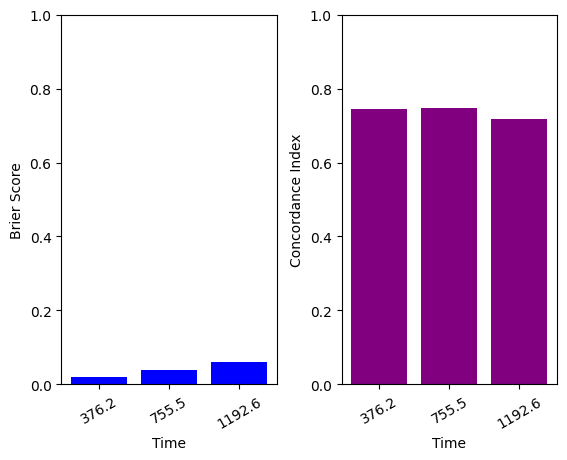

In [18]:
from auton_survival.examples.estimators_demo_utils import plot_performance_metrics

# Obtain survival probabilities for test set
predictions_te = model.predict_survival(x_test, times)

# Compute the Brier Score and time-dependent concordance index for the test set to assess model performance
results = dict()
results['Brier Score'] = survival_regression_metric('brs', outcomes=y_test, predictions=predictions_te,
                                                    times=times, outcomes_train=y_train)
results['Concordance Index'] = survival_regression_metric('ctd', outcomes=y_test, predictions=predictions_te,
                                                    times=times, outcomes_train=y_train)
plot_performance_metrics(results, times)

In [19]:
print(results['Concordance Index'])

[0.7450266965081652, 0.7461854246119881, 0.7174534823261592]
